In [1]:
import math

import matplotlib.pyplot as plt
import torch
import glob
import os.path as osp
import numpy as np
import random
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from PIL import Image
import torch.nn.functional as F

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


def make_datapath_list(rootpath):
    """
    학습, 검증용 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다.

    Parameters
    ----------
    rootpath : str
        데이터 폴더의 경로

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터의 경로를 저장한 리스트
    """

    # 화상 파일과 어노테이션 파일의 경로 템플릿을 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')

    # 훈련 및 검증 파일 각각의 ID(파일 이름)를 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 훈련 데이터의 화상 파일과 어노테이션 파일의 경로 리스트를 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 공백과 줄바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상의 경로
        anno_path = (annopath_template % file_id)  # 어노테이션의 경로
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 검증 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상의 경로
        anno_path = (annopath_template % file_id)  # 어노테이션의 경로
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [2]:
rootpath = "D:\\DaraYolo\\OgawaYutaro\\data\\VOCdevkit\\VOC2012\\"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)
print(train_img_list[0])
print(train_anno_list[0])
print(val_img_list[0])
print(val_anno_list[0])

D:\DaraYolo\OgawaYutaro\data\VOCdevkit\VOC2012\JPEGImages\2007_000032.jpg
D:\DaraYolo\OgawaYutaro\data\VOCdevkit\VOC2012\SegmentationClass\2007_000032.png
D:\DaraYolo\OgawaYutaro\data\VOCdevkit\VOC2012\JPEGImages\2007_000033.jpg
D:\DaraYolo\OgawaYutaro\data\VOCdevkit\VOC2012\SegmentationClass\2007_000033.png


In [3]:
from utils_for_3.data_augmentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor

In [4]:

class DataTransform:
    """
    화상과 어노테이션의 전처리 클래스. 훈련시와 검증시 다르게 동작한다.
    화상의 크기를 input_size x input_size로 한다.
    훈련시에 데이터 확장을 수행한다.


    Attributes
    ----------
    input_size : int
        리사이즈 대상 화상의 크기.
    color_mean : (R, G, B)
        각 색상 채널의 평균값.
    color_std : (R, G, B)
        각 색상 채널의 표준편차.
    """

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),  # 화상의 확대
                RandomRotation(angle=[-10, 10]),  # 회전
                RandomMirror(),  # 랜덤 미러
                Resize(input_size),  # 리사이즈(input_size)
                Normalize_Tensor(color_mean, color_std)  # 색상 정보의 표준화와 텐서화
            ]),
            'val': Compose([
                Resize(input_size),  # 리사이즈(input_size)
                Normalize_Tensor(color_mean, color_std)  # 색상 정보의 표준화와 텐서화
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드를 지정.
        """
        return self.data_transform[phase](img, anno_class_img)


In [5]:
class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. PyTorch의 Dataset 클래스를 상속받는다.

    Attributes
    ----------
    img_list : 리스트
        화상의 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션의 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련을 설정한다.
    transform : object
        전처리 클래스의 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''화상의 매수를 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리한 화상의 텐서 형식 데이터와 어노테이션을 취득
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        '''화상의 텐서 형식 데이터, 어노테이션을 취득한다'''

        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)  # [높이][폭][색RGB]

        # 2. 어노테이션 화상 읽기
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)  # [높이][폭]

        # 3. 전처리 실시
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img

In [6]:

# (RGB) 색의 평균치와 표준편차
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# 데이터 세트 작성
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# 데이터를 추출하는 예
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0))

torch.Size([3, 475, 475])
torch.Size([475, 475])
(tensor([[[ 1.6667,  1.5125,  1.5639,  ...,  1.7523,  1.6667,  1.7009],
         [ 1.5810,  1.4269,  1.4783,  ...,  1.7009,  1.6153,  1.6495],
         [ 1.5639,  1.4098,  1.4440,  ...,  1.6838,  1.5982,  1.6324],
         ...,
         [-0.4739, -0.4911, -0.5424,  ...,  1.2557,  1.1872,  1.2214],
         [-0.5596, -0.4911, -0.4911,  ...,  1.2385,  1.1872,  1.2214],
         [-0.6281, -0.3883, -0.3369,  ...,  1.2385,  1.1872,  1.2214]],

        [[ 1.8333,  1.6758,  1.7283,  ...,  1.9209,  1.8333,  1.8683],
         [ 1.7458,  1.5882,  1.6408,  ...,  1.8683,  1.7808,  1.8158],
         [ 1.7283,  1.5707,  1.6057,  ...,  1.8508,  1.7633,  1.7983],
         ...,
         [-0.5826, -0.6001, -0.6527,  ...,  1.4132,  1.3431,  1.3431],
         [-0.6702, -0.6001, -0.6001,  ...,  1.3957,  1.3431,  1.3431],
         [-0.7402, -0.4951, -0.4426,  ...,  1.3957,  1.3431,  1.3431]],

        [[ 2.0474,  1.8905,  1.9428,  ...,  2.1346,  2.0474,  2.08

In [7]:
batch_size = 8

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloader_dict = {"train": train_dataloader, "val": val_dataloader}

In [8]:

batch_iterator = iter(dataloader_dict["val"])
imges, anno_class_imges = next(batch_iterator)
print(imges.size())  # torch.Size([8, 3, 475, 475])
print(anno_class_imges.size())  # torch

torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


In [9]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, padding, dilation, bias):
        super().__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        output = self.relu(x)
        return output



In [10]:
class FeatureMap_convolution(nn.Module):
    def __init__(self):
        super().__init__()

        in_channel, out_channel, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self.cbnr_1 = conv2DBatchNormRelu(in_channel, out_channel, kernel_size, stride,
                                          padding, dilation, bias)
        in_channel, out_channel, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(in_channel, out_channel, kernel_size, stride,
                                          padding, dilation, bias)

        in_channel, out_channel, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(in_channel, out_channel, kernel_size, stride,
                                          padding, dilation, bias)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        output = self.maxpool(x)
        return output



In [11]:
class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, padding, dilation, bias):
        super().__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        return x



In [12]:
class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super().__init__()
        self.cbr_1 = conv2DBatchNormRelu(in_channels, mid_channels, kernel_size=1, stride=1, padding=0,
                                         dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation,
                                         dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(mid_channels, out_channels, kernel_size=1, stride=1, padding=0,
                                    dilation=1, bias=False)

        self.cb_residual = conv2DBatchNormRelu(in_channels, out_channels, kernel_size=1, stride=stride, padding=0,
                                               dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)



In [13]:
class bottleNeckIdentityPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super().__init__()
        self.cbr_1 = conv2DBatchNormRelu(in_channels, mid_channels, kernel_size=1, stride=1, padding=0,
                                         dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation,
                                         dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(mid_channels, in_channels, kernel_size=1, stride=1, padding=0,
                                    dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)


In [14]:
class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super().__init__()
        self.add_module("block1",
                        bottleNeckPSP(in_channels, mid_channels, out_channels, stride, dilation))
        for i in range(n_blocks - 1):
            self.add_module("block" + str(i + 2),
                            bottleNeckIdentityPSP(out_channels, mid_channels, stride, dilation))



In [15]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super().__init__()

        self.height, self.width = height, width
        out_channels = int(in_channels / len(pool_sizes))

        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1,
                                         bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size=1, stride=1, padding=0,
                                         dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size=1, stride=1, padding=0,
                                         dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(in_channels, out_channels, kernel_size=1, stride=1, padding=0,
                                         dilation=1, bias=False)

    def forward(self, x):
        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(self.height, self.width), mode="bilinear", align_corners=True)
        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(self.height, self.width), mode="bilinear", align_corners=True)
        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(self.height, self.width), mode="bilinear", align_corners=True)
        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(self.height, self.width), mode="bilinear", align_corners=True)

        output = torch.cat([x, out1, out2, out3, out4], dim=1)
        return output

In [16]:
class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super().__init__()

        self.height, self.width = height, width

        self.cbr = conv2DBatchNormRelu(in_channel=4096,
                                       out_channel=512,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1,
                                       dilation=1,
                                       bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(in_channels=512,
                                        out_channels=n_classes,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True
        )
        return output



In [17]:
class AuxiliaryPSPlayers(nn.Module):
    def __init__(self, in_channels,
                 height,
                 wdith,
                 n_classes):
        super().__init__()
        self.width, self.height = wdith, height

        self.cbr = conv2DBatchNormRelu(in_channel=in_channels,
                                       out_channel=256,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1,
                                       dilation=1,
                                       bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(in_channels=256,
                                        out_channels=n_classes,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True
        )
        return output



In [18]:


class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        block_config = [3, 4, 6, 3]
        img_size = 475
        img_size_8 = 60

        self.feature_conv = FeatureMap_convolution()
        self.feature_res_1 = ResidualBlockPSP(n_blocks=block_config[0],
                                              in_channels=128,
                                              mid_channels=64,
                                              out_channels=256,
                                              stride=1,
                                              dilation=1)
        self.feature_res_2 = ResidualBlockPSP(n_blocks=block_config[1],
                                              in_channels=256,
                                              mid_channels=128,
                                              out_channels=512,
                                              stride=2,
                                              dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2],
            in_channels=512,
            mid_channels=256,
            out_channels=1024,
            stride=1, dilation=2
        )
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3],
            in_channels=1024,
            mid_channels=512,
            out_channels=2048,
            stride=1, dilation=4
        )
        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[6, 3, 2, 1], height=img_size_8,
                                              width=img_size_8)
        self.decode_feature = DecodePSPFeature(height=img_size,
                                               width=img_size,
                                               n_classes=n_classes)
        self.aux = AuxiliaryPSPlayers(in_channels=1024,
                                      height=img_size,
                                      wdith=img_size,
                                      n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)

        x = self.feature_dilated_res_2(x)
        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)
        return output, output_aux

In [19]:
net = PSPNet(n_classes=21)
print(net)

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [20]:
# 더미 데이터
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 475, 475)
outputs = net(dummy_img)
print(outputs)

(tensor([[[[-0.3360, -0.3360, -0.3360,  ..., -0.1409, -0.0786, -0.0164],
          [-0.2761, -0.2859, -0.2957,  ..., -0.1447, -0.0870, -0.0293],
          [-0.2162, -0.2358, -0.2553,  ..., -0.1484, -0.0954, -0.0423],
          ...,
          [ 0.1137,  0.1343,  0.1550,  ..., -0.1733, -0.2305, -0.2878],
          [ 0.1092,  0.1382,  0.1673,  ..., -0.2027, -0.2620, -0.3213],
          [ 0.1046,  0.1421,  0.1796,  ..., -0.2321, -0.2934, -0.3548]],

         [[-0.0070,  0.0018,  0.0107,  ...,  0.3361,  0.3467,  0.3573],
          [ 0.0096,  0.0178,  0.0260,  ...,  0.2938,  0.2980,  0.3023],
          [ 0.0262,  0.0338,  0.0414,  ...,  0.2515,  0.2494,  0.2474],
          ...,
          [ 0.1990,  0.1566,  0.1143,  ...,  0.1983,  0.2398,  0.2814],
          [ 0.1974,  0.1528,  0.1082,  ...,  0.2007,  0.2444,  0.2880],
          [ 0.1958,  0.1490,  0.1021,  ...,  0.2031,  0.2489,  0.2947]],

         [[-0.1886, -0.2012, -0.2138,  ...,  0.1346,  0.2045,  0.2744],
          [-0.2129, -0.2158, 

In [21]:
# ADE20k 클래스 수는 150개
net = PSPNet(n_classes=150)

In [22]:
state_dict = torch.load("D:/DaraYolo/OgawaYutaro/weights/pspnet50_ADE20K.pth")

C:\Users\eu\AppData\Local\Temp\ipykernel_7184\1352418061.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("D:/DaraYolo/OgawaYutaro/weights/pspnet5

In [23]:
net.load_state_dict(state_dict)

<All keys matched successfully>

In [24]:
n_classes = 21
net.decode_feature.classification = nn.Conv2d(in_channels=512,
                                              out_channels=n_classes,
                                              kernel_size=1,
                                              stride=1,
                                              padding=0)


In [25]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)


net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)
print("network configuration completed")

network configuration completed


In [26]:
class PSPLoss(nn.Module):
    def __init__(self, aux_weight=0.4):
        super().__init__()
        self.aux_weight = aux_weight

    def forward(self, outputs, targets):
        loss = F.cross_entropy(outputs[0], targets, reduction="mean")
        loss_aux = F.cross_entropy(outputs[1], targets, reduction="mean")

        return loss + self.aux_weight * loss_aux


criterion = PSPLoss(aux_weight=0.4)

In [27]:
import math

optimizer = optim.SGD([
    {"params": net.feature_conv.parameters(), "lr": 1e-3},
    {"params": net.feature_res_1.parameters(), "lr": 1e-3},
    {"params": net.feature_res_2.parameters(), "lr": 1e-3},
    {"params": net.feature_dilated_res_1.parameters(), "lr": 1e-3},
    {"params": net.feature_dilated_res_2.parameters(), "lr": 1e-3},
    {"params": net.pyramid_pooling.parameters(), "lr": 1e-3},
    {"params": net.decode_feature.parameters(), "lr": 1e-2},
    {"params": net.aux.parameters(), "lr": 1e-2},
], momentum=0.9, weight_decay=0.0001)


def lambda_epoch(epoch):
    max_epoch = 30
    return math.pow((1 - epoch / max_epoch), 0.9)


In [28]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

In [29]:
# import pandas as pd
# import time
#
#
# def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print("사용장치: ", device)
#
#     net.to(device)
#
#     torch.backends.cudnn.benchmark = True
#
#     num_train_imgs = len(dataloaders_dict['train'].dataset)
#     num_val_imgs = len(dataloaders_dict['val'].dataset)
#     batch_size = dataloaders_dict['train'].batch_size
#
#     iteration = 1
#     logs = []
#
#     batch_multiplier = 3
#
#     for epoch in range(num_epochs):
#         t_epoch_start = time.time()
#         t_iter_start = time.time()
#         epoch_train_loss = 0.0
#         epoch_val_loss = 0.0
#
#         print("-------------")
#         print("Epoch {}/{}".format(epoch + 1, num_epochs))
#         print("--------------")
#
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 net.train()
#                 optimizer.zero_grad()
#                 scheduler.step()
#                 print("train")
#             else:
#                 if ((epoch + 1) % 5) == 0:
#                     net.eval()
#                     print("------------")
#                     print("val")
#                 else:
#                     continue
#
#             count = 0
#             for imges, anno_class_imges in dataloaders_dict[phase]:
#                 if imges.size()[0] == 1:
#                     continue
#
#                 imges = imges.to(device)
#                 anno_class_imges = anno_class_imges.to(device)
#
#                 if (phase == 'train') and (count == 0):
#                     optimizer.zero_grad()
#                     optimizer.step()
#                     count = batch_multiplier
#
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = net(imges)
#                     loss = criterion(outputs, anno_class_imges.long()) / batch_multiplier
#
#                     if phase == 'train':
#                         loss.backward()
#                         count -= 1
#
#                         if iteration % 10 == 0:
#                             t_iter_end = time.time()
#                             duration = t_iter_end - t_iter_start
#                             print("반복: {} || Loss: {:.4f} || 10iter: {:.4f}  sec.".format(
#                                 iteration, loss.item() / batch_size * batch_multiplier, duration
#                             ))
#                             t_iter_start = time.time()
#                         epoch_train_loss += loss.item() * batch_multiplier
#                         iteration += 1
#                     else:
#                         epoch_val_loss += loss.item() * batch_multiplier
#         t_epoch_finish = time.time()
#         print("-----------------")
#         print("Epoch {} || Epoch_TRAIN_Loss:{:.4f} || Epoch_VAL_Loss:{:.4f}".format(
#             epoch + 1,
#             epoch_train_loss / num_train_imgs,
#             epoch_val_loss / num_val_imgs
#         ))
#         print("timer: {:.4f} sec.".format(t_epoch_finish - t_epoch_start))
#
#         t_epoch_start = time.time()
#
#         log_epoch = {"epoch": epoch + 1,
#                      "train_loss": epoch_train_loss / num_train_imgs,
#                      "val_loss": epoch_val_loss / num_val_imgs}
#         logs.append(log_epoch)
#         df = pd.DataFrame(logs)
#         df.to_csv("log.csv")
#
#     torch.save(net.state_dict(), "weights/pspnet50_" + str(epoch + 1) + ".pth")

In [30]:
%%time
import pandas as pd
import time
import torch


def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):
    # 사용 가능한 장치 설정
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용장치: ", device)

    # 모델을 GPU로 이동
    net.to(device)

    # cudnn을 활용하여 고속화
    torch.backends.cudnn.benchmark = True

    # 데이터셋의 크기
    num_train_imgs = len(dataloaders_dict['train'].dataset)
    num_val_imgs = len(dataloaders_dict['val'].dataset)
    batch_size = dataloaders_dict['train'].batch_size

    # 반복자 카운터 초기화
    iteration = 1
    logs = []

    # minibatch 배수 설정
    batch_multiplier = 3

    # 학습 및 검증 루프
    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        print("-------------")
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print("--------------")

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()

                # optimizer.step() 전에 scheduler.step()을 호출해야 경고가 발생하지 않음
                optimizer.zero_grad()  # 그래디언트 초기화
                optimizer.step()  # 모델 파라미터 업데이트
                scheduler.step()  # 학습률 조정

                print("train")
            else:
                if ((epoch + 1) % 5) == 0:
                    net.eval()
                    print("------------")
                    print("val")
                else:
                    continue

            count = 0
            for imges, anno_class_imges in dataloaders_dict[phase]:
                # 미니배치 크기가 1일 때, 배치 정규화에서 오류를 방지하기 위해 건너뛴다
                if imges.size()[0] == 1:
                    continue

                imges = imges.to(device)
                anno_class_imges = anno_class_imges.to(device)

                if (phase == 'train') and (count == 0):
                    optimizer.zero_grad()  # 그래디언트 초기화
                    optimizer.step()  # 모델 파라미터 업데이트
                    count = batch_multiplier

                # 순전파 및 손실 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(imges)
                    loss = criterion(outputs, anno_class_imges.long()) / batch_multiplier

                    if phase == 'train':
                        loss.backward()  # 역전파 계산
                        count -= 1

                        # 10번의 반복마다 손실 출력
                        if iteration % 10 == 0:
                            t_iter_end = time.time()
                            duration = t_iter_end - t_iter_start
                            print("반복: {} || Loss: {:.4f} || 10iter: {:.4f}  sec.".format(
                                iteration, loss.item() / batch_size * batch_multiplier, duration
                            ))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier

        t_epoch_finish = time.time()
        print("-----------------")
        print("Epoch {} || Epoch_TRAIN_Loss:{:.4f} || Epoch_VAL_Loss:{:.4f}".format(
            epoch + 1,
            epoch_train_loss / num_train_imgs,
            epoch_val_loss / num_val_imgs
        ))
        print("timer: {:.4f} sec.".format(t_epoch_finish - t_epoch_start))

        t_epoch_start = time.time()

        # 로그 저장
        log_epoch = {"epoch": epoch + 1,
                     "train_loss": epoch_train_loss / num_train_imgs,
                     "val_loss": epoch_val_loss / num_val_imgs}
        logs.append(log_epoch)

        # DataFrame으로 로그 저장 후 csv로 출력
        df = pd.DataFrame(logs)
        df.to_csv("log.csv")

    # 훈련이 끝난 후 네트워크 모델 저장
    torch.save(net.state_dict(), "weights/pspnet50_" + str(epoch + 1) + ".pth")


CPU times: total: 219 ms
Wall time: 870 ms


In [31]:
# %%time
# num_epochs = 30
# train_model(net, dataloader_dict, criterion, scheduler, optimizer, num_epochs)

In [32]:
state_dict = torch.load("D:/DaraYolo/OgawaYutaro/weights/pspnet50_.pth")

C:\Users\eu\AppData\Local\Temp\ipykernel_7184\4117140825.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("D:/DaraYolo/OgawaYutaro/weights/pspnet5

In [1]:
net = PSPNet(n_classes=21)
net.load_state_dict(state_dict)
print("network configuration completed")

NameError: name 'PSPNet' is not defined

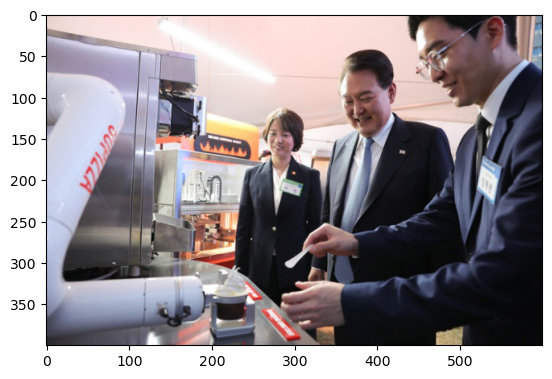

In [34]:
import matplotlib.pyplot as plt

image_file_path = "D:/DaraYolo/OgawaYutaro/data/yun.jpg"
img = Image.open(image_file_path)
img_width, img_height = img.size
plt.imshow(img)
plt.show()

In [35]:
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(input_size=475,
                          color_mean=color_mean,
                          color_std=color_std)

In [36]:
# 역할:
# 검증용 어노테이션 파일 경로(val_anno_list)를 가져옵니다.
# PIL 라이브러리의 Image.open을 사용하여 어노테이션 이미지를 엽니다.
# getpalette()를 호출하여 어노테이션 이미지의 색상 팔레트를 가져옵니다.
# 어노테이션 파일: 보통 클래스별로 다른 색상을 가지며, 픽셀 단위로 클래스 정보를 포함합니다.
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)
p_palette = anno_class_img.getpalette()
phase = 'val'


In [37]:
img, anno_class_img = transform(phase, img, anno_class_img)

In [38]:
net.eval()

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [39]:
# 입력 이미지 img의 차원을 확장합니다.
# PyTorch 모델은 배치 차원(batch dimension)을 포함한 4D 텐서를 입력으로 받습니다. 따라서, (C,H,W) 형태의 3D 텐서를 (1,C,H,W)로 변환해야 합니다.
# C: 채널 수 (예: RGB라면 3)
# H,W: 이미지의 높이와 너비
# 결과: img는 배치 크기가 1인 4D 텐서가 됩니다.
x = img.unsqueeze(0)

# PSPNet 모델 net에 입력 텐서 x를 전달하여 결과를 얻습니다.
# output: 최종 분류 결과 (픽셀 단위 클래스 예측)
# output_aux: 보조 출력 (auxiliary loss 계산용 중간 결과)
outputs = net(x)

# PSPNet의 첫 번째 출력인 output을 선택합니다.
# output은 최종 분류 맵으로, 각 픽셀에 대해 클래스 확률 또는 클래스 ID를 나타냅니다.
# 크기:(N,C,H,W) N: 배치 크기 (여기서는 1), C: 클래스 수. H,W: 출력 맵의 높이와 너비
y = outputs[0]

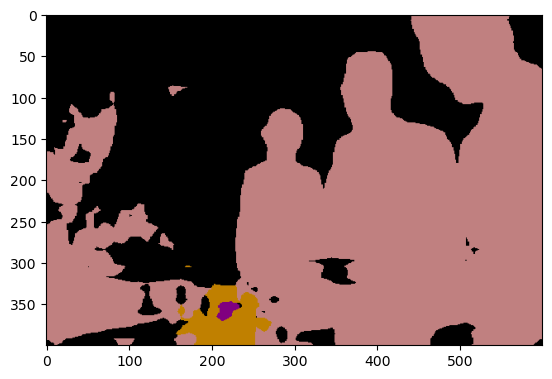

In [40]:
# y: PSPNet의 출력 중 첫 번째 배치(단일 이미지 결과)를 선택합니다.
# .detach(): PyTorch의 계산 그래프에서 분리하여 텐서를 고정합니다. 이는 역전파를 방지하기 위함입니다.
# .numpy(): PyTorch 텐서를 NumPy 배열로 변환합니다.
y = y[0].detach().numpy()

# np.argmax(y, axis=0): 클래스 차원(C)에서 가장 높은 값을 가지는 인덱스를 선택합니다.
# 이는 각 픽셀에 대해 가장 높은 확률을 가진 클래스를 예측하는 과정입니다.
# 결과:  (H,W) 크기의 2D 배열이 생성되며, 각 픽셀은 해당하는 클래스 ID를 가집니다.
y = np.argmax(y, axis=0)

# np.uint8(y): 클래스 ID를 8비트 정수형으로 변환합니다.
# Image.fromarray: NumPy 배열을 PIL 이미지 객체로 변환합니다.
# mode="P": 팔레트 모드를 사용하여 색상 맵핑을 가능하게 합니다.
anno_class_img = Image.fromarray(np.uint8(y), mode="P")

# resize: PIL 이미지를 원본 이미지 크기(img_width, img_height)로 조정합니다.
# Image.NEAREST: 최근접 이웃 보간법을 사용하여 픽셀 값을 유지합니다.
# 결과: 어노테이션 이미지가 원본 이미지 크기로 확장됩니다.
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)

# putpalette(p_palette): 어노테이션 이미지에 색상 팔레트를 적용합니다.
# p_palette: 원본 어노테이션 이미지에서 가져온 팔레트 정보로, 각 클래스 ID에 대응하는 색상을 정의합니다.
# 결과: 어노테이션 이미지가 시각적으로 구별 가능한 색상을 가지게 됩니다.
anno_class_img.putpalette(p_palette)

plt.imshow(anno_class_img)

In [41]:
# Image.new: 새로운 이미지를 생성합니다.
# "RGBA": 이미지 모드를 RGBA로 설정합니다. 이는 Red, Green, Blue, Alpha(투명도) 채널을 포함하는 이미지 형식입니다.
# anno_class_img.size: 기존 어노테이션 이미지와 동일한 크기를 지정합니다.
# (0, 0, 0, 0): 초기 색상값을 완전히 투명한 검정색으로 설정합니다.
# 결과: 투명한 배경을 가진 RGBA 이미지(trans_img)가 생성됩니다.
trans_img = Image.new("RGBA", anno_class_img.size, (0, 0, 0, 0))

# convert("RGBA"): 기존 어노테이션 이미지를 RGBA 모드로 변환합니다.
# 이는 어노테이션 이미지에 알파 채널(투명도)을 추가하여 배경과 잘 결합되도록 합니다.
# 결과: 어노테이션 이미지(anno_class_img)가 RGBA 모드로 변환됩니다.
anno_class_img = anno_class_img.convert("RGBA")

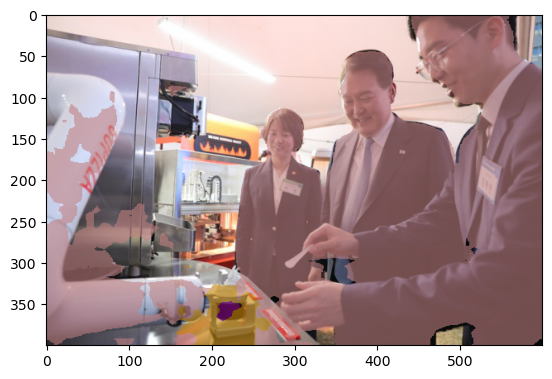

In [42]:
# 어노테이션 이미지(anno_class_img)의 각 픽셀을 순회하며 RGBA 값을 가져옵니다.
# 픽셀 색상이 (0, 0, 0)인 경우(즉, 배경인 경우) 아무 작업도 하지 않고 넘어갑니다.
# 배경이 아닌 경우, 해당 픽셀을 투명도를 조정한 값 (r, g, b, 200)으로 투명 이미지(trans_img)에 설정합니다.
# 알파 값(투명도) 200은 약간의 반투명을 의미합니다.
# 결과: 클래스 색상 정보가 포함된 투명한 어노테이션 이미지(trans_img)가 생성됩니다.
for x in range(img_width):
    for y in range(img_height):
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            trans_img.putpixel((x, y), (r, g, b, 200))

img = Image.open(image_file_path)
result = Image.alpha_composite(img.convert("RGBA"), trans_img)
plt.imshow(result)
plt.show()